# Artificial Intelligence in Finance

## Reinforcement Learning

## Imports

In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(precision=4, suppress=True)
os.environ['PYTHONHASHSEED'] = '0'

## `CartPole` Environment 

In [2]:
import gym

In [3]:
env = gym.make('CartPole-v0')

In [4]:
env.seed(100)
env.action_space.seed(100)

[100]

In [5]:
env.observation_space

Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)

In [6]:
env.observation_space.low.astype(np.float16)

array([-4.8  ,   -inf, -0.419,   -inf], dtype=float16)

In [7]:
env.observation_space.high.astype(np.float16)

array([4.8  ,   inf, 0.419,   inf], dtype=float16)

In [8]:
state = env.reset()

In [9]:
state

array([-0.0163,  0.0238, -0.0392, -0.0148])

In [10]:
env.action_space

Discrete(2)

In [11]:
env.action_space.n

2

In [12]:
env.action_space.sample()

1

In [13]:
env.action_space.sample() 

0

In [14]:
a = env.action_space.sample()
a

1

In [15]:
state, reward, done, info = env.step(a)
state, reward, done, info

(array([-0.0158,  0.2195, -0.0395, -0.3196]), 1.0, False, {})

In [16]:
env.reset()
for e in range(1, 200):
    a = env.action_space.sample()
    state, reward, done, info = env.step(a) 
    print(f'step={e:2d} | state={state} | action={a} | reward={reward}')
    if done and (e + 1) < 200:
        print('*** FAILED ***')
        break

step= 1 | state=[-0.0423  0.1982  0.0256 -0.2476] | action=1 | reward=1.0
step= 2 | state=[-0.0383  0.0028  0.0206  0.0531] | action=0 | reward=1.0
step= 3 | state=[-0.0383  0.1976  0.0217 -0.2331] | action=1 | reward=1.0
step= 4 | state=[-0.0343  0.0022  0.017   0.0664] | action=0 | reward=1.0
step= 5 | state=[-0.0343  0.197   0.0184 -0.2209] | action=1 | reward=1.0
step= 6 | state=[-0.0304  0.0016  0.0139  0.0775] | action=0 | reward=1.0
step= 7 | state=[-0.0303  0.1966  0.0155 -0.2107] | action=1 | reward=1.0
step= 8 | state=[-0.0264  0.0012  0.0113  0.0868] | action=0 | reward=1.0
step= 9 | state=[-0.0264  0.1962  0.013  -0.2023] | action=1 | reward=1.0
step=10 | state=[-0.0224  0.3911  0.009  -0.4908] | action=1 | reward=1.0
step=11 | state=[-0.0146  0.5861 -0.0009 -0.7807] | action=1 | reward=1.0
step=12 | state=[-0.0029  0.7812 -0.0165 -1.0736] | action=1 | reward=1.0
step=13 | state=[ 0.0127  0.9766 -0.0379 -1.3714] | action=1 | reward=1.0
step=14 | state=[ 0.0323  1.1722 -0.06

In [17]:
done

True

## Dimensionality Reduction

See http://kvfrans.com/simple-algoritms-for-solving-cartpole/.

In [18]:
np.random.seed(100)

In [19]:
weights = np.random.random(4) * 2 - 1

In [20]:
weights

array([ 0.0868, -0.4433, -0.151 ,  0.6896])

In [21]:
state = env.reset()

In [22]:
state

array([-0.0347, -0.0103,  0.047 , -0.0315])

In [23]:
s = np.dot(state, weights)
s

-0.02725361929630797

## Action Rule

In [24]:
if s < 0:
    a = 0
else:
    a = 1

In [25]:
a

0

## Total Reward per Episode

In [26]:
def run_episode(env, weights):  
    state = env.reset()
    treward = 0
    for _ in range(200):
        s = np.dot(state, weights)
        a = 0 if s < 0 else 1
        state, reward, done, info = env.step(a)
        treward += reward
        if done:
            break
    return treward

In [27]:
run_episode(env, weights)

41.0

## Simple Learning 

In [28]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    env.seed(seed)

In [29]:
set_seeds()
num_episodes = 1000

In [30]:
besttreward = 0
for e in range(1, num_episodes + 1):
    weights = np.random.rand(4) * 2 - 1
    treward = run_episode(env, weights)
    if treward > besttreward:
        besttreward = treward
        bestweights = weights
        if treward == 200:
            print(f'SUCCESS | episode={e}')
            break
        print(f'UPDATE  | episode={e}')

UPDATE  | episode=1
UPDATE  | episode=2
SUCCESS | episode=13


In [31]:
weights

array([-0.4282,  0.7048,  0.95  ,  0.7697])

## Testing the Results

In [32]:
res = []
for _ in range(100):
    treward = run_episode(env, weights)
    res.append(treward)
res[:10]

[200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0]

In [33]:
sum(res) / len(res)

200.0

## DNN Learning

In [34]:
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

In [35]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [36]:
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from sklearn.metrics import accuracy_score

In [37]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    env.seed(seed)
    env.action_space.seed(seed)

In [38]:
class NNAgent:
    def __init__(self):
        self.max = 0
        self.scores = list()
        self.memory = list()
        self.model = self._build_model()
        
    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=4,
                        activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                      optimizer=RMSprop(lr=0.001))
        return model
        
    def act(self, state):
        if random.random() <= 0.5:
            return env.action_space.sample()
        action = np.where(self.model.predict(
            state, batch_size=None)[0, 0] > 0.5, 1, 0)
        return action
                    
    def train_model(self, state, action):
        self.model.fit(state, np.array([action,]),
                       epochs=1, verbose=False)
    
    def learn(self, episodes):
        for e in range(1, episodes + 1):
            state = env.reset()
            for _ in range(201):
                state = np.reshape(state, [1, 4])
                action = self.act(state)
                next_state, reward, done, info = env.step(action)
                if done:
                    score = _ + 1
                    self.scores.append(score)
                    self.max = max(score, self.max)
                    print('episode: {:4d}/{} | score: {:3d} | max: {:3d}'
                          .format(e, episodes, score, self.max), end='\r')
                    break
                self.memory.append((state, action))
                self.train_model(state, action)
                state = next_state

In [39]:
set_seeds(100)
agent = NNAgent()

In [40]:
episodes = 1000

In [41]:
agent.learn(episodes)

C:\Users\Public\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [42]:
sum(agent.scores) / len(agent.scores)

13.942

In [43]:
f = np.array([m[0][0] for m in agent.memory])
f

array([[-0.0163,  0.0238, -0.0392, -0.0148],
       [-0.0158,  0.2195, -0.0395, -0.3196],
       [-0.0114,  0.0249, -0.0459, -0.0396],
       ...,
       [-0.0657, -1.3498,  0.0954,  2.0551],
       [-0.0927, -1.1557,  0.1365,  1.7934],
       [-0.1158, -0.9624,  0.1724,  1.546 ]])

In [44]:
l = np.array([m[1] for m in agent.memory])
l

array([1, 0, 0, ..., 1, 1, 0])

In [45]:
accuracy_score(np.where(agent.model.predict(f) > 0.5, 1, 0), l)

0.7477205995982074

## Q Learning

See https://keon.io/deep-q-learning/

In [46]:
from collections import deque
from keras.optimizers import Adam, RMSprop

In [47]:
class DQLAgent:
    def __init__(self, gamma=0.95, hu=24, opt=Adam,
           lr=0.001, finish=False):
        self.finish = finish
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.gamma = gamma
        self.batch_size = 32
        self.max_treward = 0
        self.averages = list()
        self.memory = deque(maxlen=2000)
        self.osn = env.observation_space.shape[0]
        self.model = self._build_model(hu, opt, lr)
        
    def _build_model(self, hu, opt, lr):
        model = Sequential()
        model.add(Dense(hu, input_dim=self.osn,
                        activation='relu'))
        model.add(Dense(hu, activation='relu'))
        model.add(Dense(env.action_space.n, activation='linear'))
        model.compile(loss='mse', optimizer=opt(lr=lr))
        return model
        
    def act(self, state):
        if random.random() <= self.epsilon:
            return env.action_space.sample()
        action = self.model.predict(state)[0]
        return np.argmax(action)
    
    def replay(self):
        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in batch:
            if not done:
                reward += self.gamma * np.amax(
                    self.model.predict(next_state)[0])
            target = self.model.predict(state)
            target[0, action] = reward
            self.model.fit(state, target, epochs=1,
                           verbose=False)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def learn(self, episodes):
        trewards = []
        for e in range(1, episodes + 1):
            state = env.reset()
            state = np.reshape(state, [1, self.osn])
            for _ in range(5000):
                action = self.act(state)
                next_state, reward, done, info = env.step(action)
                next_state = np.reshape(next_state,
                                        [1, self.osn])
                self.memory.append([state, action, reward,
                                     next_state, done])
                state = next_state
                if done:
                    treward = _ + 1
                    trewards.append(treward)
                    av = sum(trewards[-25:]) / 25
                    self.averages.append(av)
                    self.max_treward = max(self.max_treward, treward)
                    templ = 'episode: {:4d}/{} | treward: {:4d} | '
                    templ += 'av: {:6.1f} | max: {:4d}'
                    print(templ.format(e, episodes, treward, av,
                                       self.max_treward), end='\r')
                    break
            if av > 195 and self.finish:
                print()
                break
            if len(self.memory) > self.batch_size:
                self.replay()
    def test(self, episodes):
        trewards = []
        for e in range(1, episodes + 1):
            state = env.reset()
            for _ in range(5001):
                state = np.reshape(state, [1, self.osn])
                action = np.argmax(self.model.predict(state)[0])
                next_state, reward, done, info = env.step(action)
                state = next_state
                if done:
                    treward = _ + 1
                    trewards.append(treward)
                    print('episode: {:4d}/{} | treward: {:4d}'
                          .format(e, episodes, treward), end='\r')
                    break
        return trewards

In [48]:
episodes = 1000

In [49]:
set_seeds(100)
agent = DQLAgent(finish=True)

In [50]:
%time agent.learn(episodes)

Wall time: 6min 48s| treward:  156 | av:  144.2 | max:  200


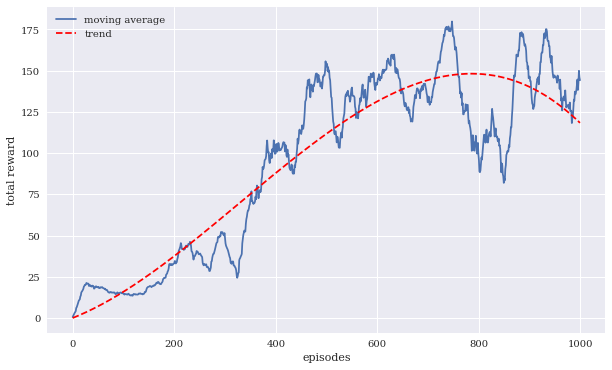

In [51]:
plt.figure(figsize=(10, 6))
x = range(len(agent.averages))
y = np.polyval(np.polyfit(x, agent.averages, deg=3), x)
plt.plot(agent.averages, label='moving average')
plt.plot(x, y, 'r--', label='trend')
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.legend();

In [52]:
trewards = agent.test(100)

In [53]:
sum(trewards) / len(trewards)

159.34

## Finance Environment

In [54]:
class observation_space:
    def __init__(self, n):
        self.shape = (n,)

In [55]:
class action_space:
    def __init__(self, n):
        self.n = n
    def seed(self, seed):
        pass
    def sample(self):
        return random.randint(0, self.n - 1)

In [56]:
class Finance:
    url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'
    def __init__(self, symbol, features):
        self.symbol = symbol
        self.features = features
        self.observation_space = observation_space(4)
        self.osn = self.observation_space.shape[0]
        self.action_space = action_space(2)
        self.min_accuracy = 0.475
        self._get_data()
        self._prepare_data()
    def _get_data(self):
        self.raw = pd.read_csv(self.url, index_col=0,
                               parse_dates=True).dropna()
    def _prepare_data(self):
        self.data = pd.DataFrame(self.raw[self.symbol])
        self.data['r'] = np.log(self.data / self.data.shift(1))
        self.data.dropna(inplace=True)
        self.data = (self.data - self.data.mean()) / self.data.std()
        self.data['d'] = np.where(self.data['r'] > 0, 1, 0)
    def _get_state(self):
        return self.data[self.features].iloc[
            self.bar - self.osn:self.bar].values
    def seed(self, seed=None):
        pass
    def reset(self):
        self.treward = 0
        self.accuracy = 0
        self.bar = self.osn
        state = self.data[self.features].iloc[
            self.bar - self.osn:self.bar]
        return state.values
    def step(self, action):
        correct = action == self.data['d'].iloc[self.bar]
        reward = 1 if correct else 0
        self.treward += reward
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.osn)
        if self.bar >= len(self.data):
            done = True
        elif reward == 1:
            done = False
        elif (self.accuracy < self.min_accuracy and
              self.bar > self.osn + 10):
            done = True
        else:
            done = False
        state = self._get_state()
        info = {}
        return state, reward, done, info

In [57]:
env = Finance('EUR=', 'EUR=')

In [58]:
env.reset()

array([1.819 , 1.8579, 1.7749, 1.8579])

In [59]:
a = env.action_space.sample()
a

1

In [60]:
env.step(a)

(array([1.8579, 1.7749, 1.8579, 1.947 ]), 1, False, {})

In [61]:
set_seeds(100)
agent = DQLAgent(gamma=0.5, opt=RMSprop)

In [62]:
episodes = 1000

In [63]:
%time agent.learn(episodes)

C:\Users\Public\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Wall time: 24min 12s treward:   11 | av:  911.0 | max: 2511


In [64]:
agent.test(3)

[11, 11, 11]

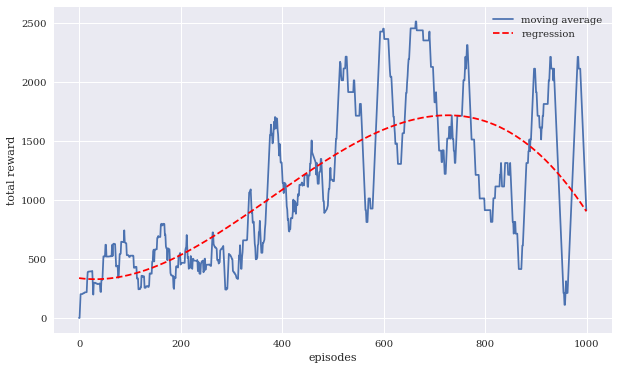

In [65]:
plt.figure(figsize=(10, 6))
x = range(len(agent.averages))
y = np.polyval(np.polyfit(x, agent.averages, deg=3), x)
plt.plot(agent.averages, label='moving average')
plt.plot(x, y, 'r--', label='regression')
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.legend();